# 2. Density Based Clustering 

Density-Based Clustering groups data points based on areas of high density, separating regions of low density as outliers. A popular algorithm like DBSCAN identifies clusters without requiring the number of clusters in advance.


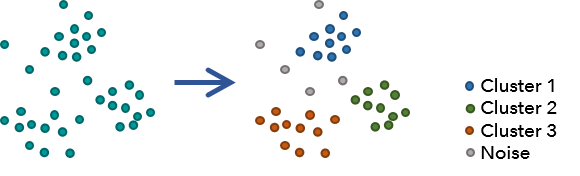


#  What is DBSCAN?

DBSCAN is an unsupervised clustering algorithm that groups together closely packed data points (high-density regions), and marks points in low-density regions as outliers/noise. Unlike K-Means, it doesn’t require the number of clusters to be specified beforehand

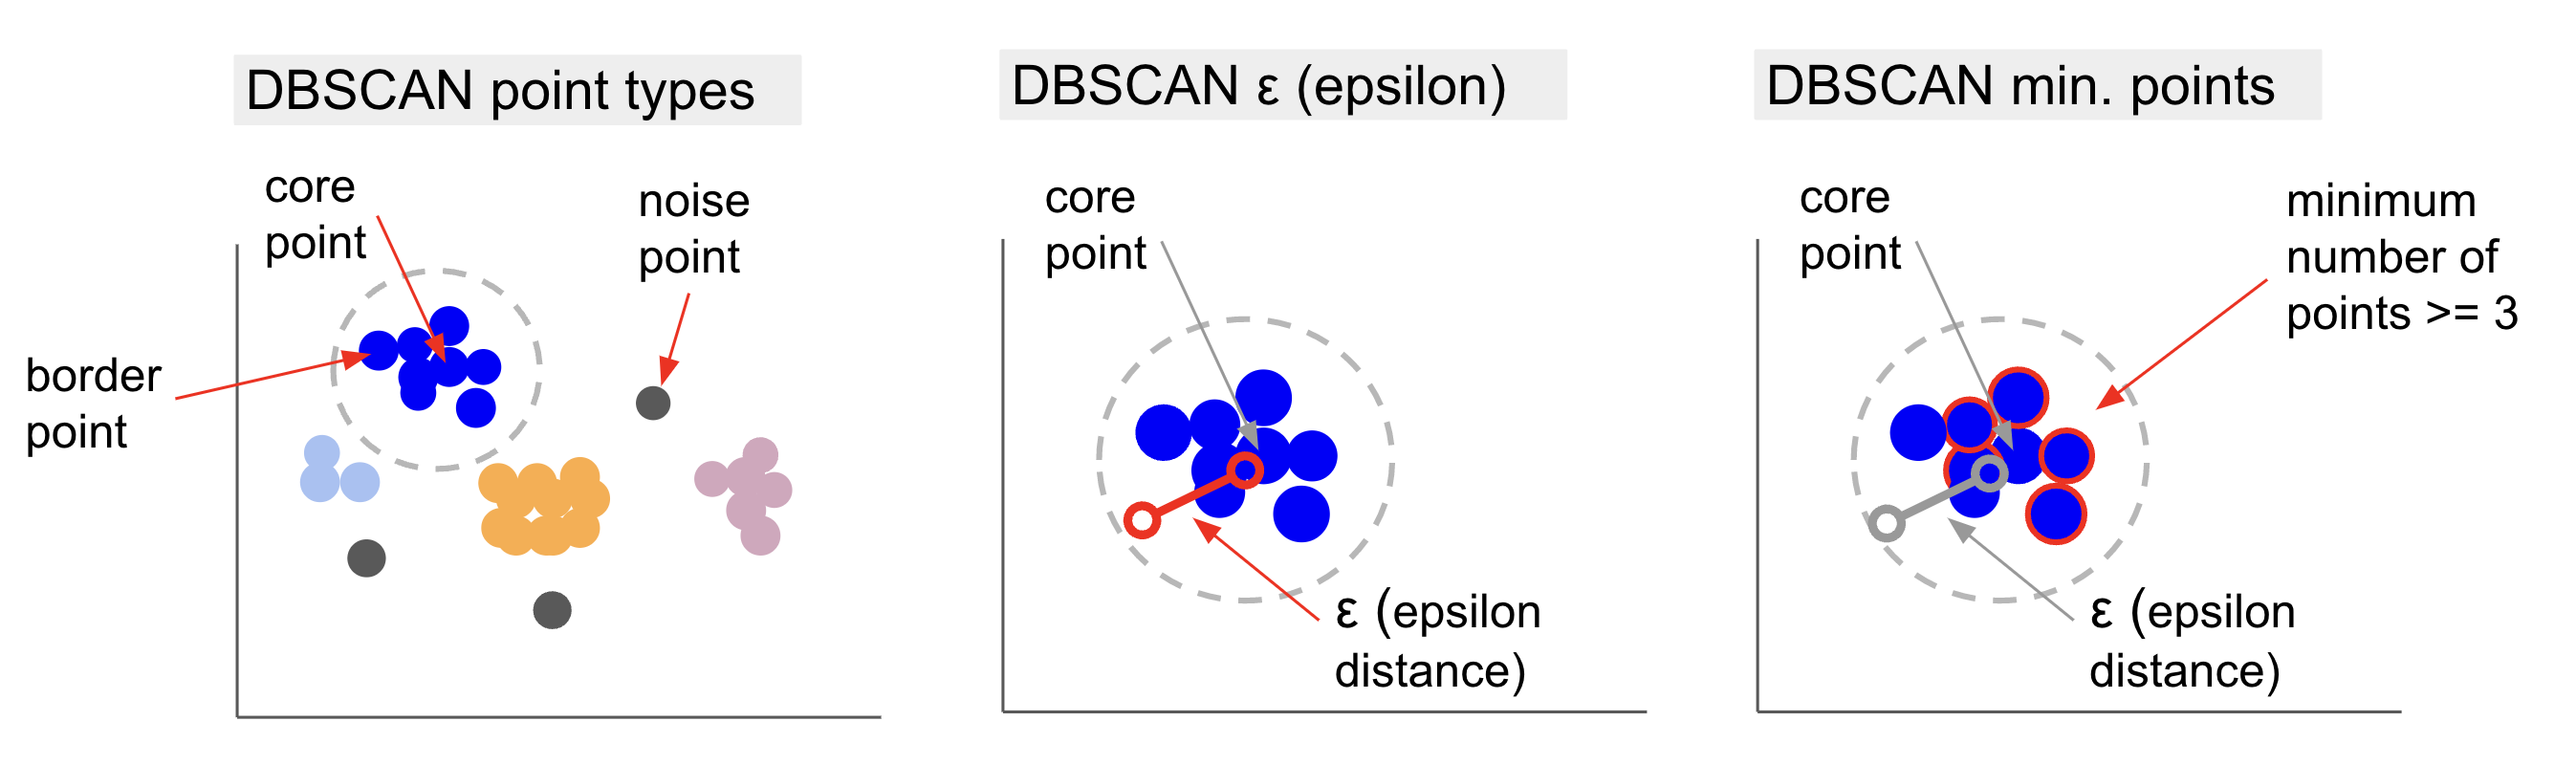

## How DBSCAN Works – Step-by-Step

1. Choose two parameters:

            eps: Radius of the neighborhood.

            min_samples: Minimum number of points required to form a dense region.

2. For each point in the dataset:

            Count how many points fall within eps distance.

            If count ≥ min_samples: it's a core point.

            If it's in the neighborhood of a core point, it's a border point.

            Otherwise, it's labeled as noise.

3. Connect core points within eps distance → form a cluster.

4. Border points are added to the cluster.

5. Noise remains unassigned.

# Problem Statement:
A large shopping mall wants to identify natural groupings of Wi-Fi access points (APs) based on:

            Signal strength (RSSI),

            Foot traffic near the APs, and

            Distance from the mall center.

They do not know how many zones exist, and there might be outliers (e.g., test routers or isolated locations). DBSCAN is ideal due to its ability to detect arbitrary-shaped clusters and handle noise.


 # Insights
 
Cluster 0: Central, strong signal, high traffic (main lobby).

Cluster 1: Moderate signal, moderate traffic (shops area).

Cluster 2: Weak signal, lower traffic (far end/corners).

Noise: Random or test APs in isolated zones.

# Dataset Overview
title: WI-FI Received Signal Strength (RSSI) Dataset


Format: Single CSV file

Features:

        RSSI Measurements: Received Signal Strength Indicator values from multiple APs.

        Location Coordinates: Positional data indicating where measurements were taken.

        Timestamp: Time of each measurement, useful for temporal analysis.
        Kaggle


# Load Dataset

In [3]:
import pandas as pd 
import numpy as np

# Simulate data for 3 main zones and some noise
zone1 = np.random.normal(loc=[-30, 200, 20], scale=[3, 20, 5], size=(30, 3))
zone2 = np.random.normal(loc=[-45, 150, 40], scale=[3, 15, 5], size=(30, 3))
zone3 = np.random.normal(loc=[-60, 100, 60], scale=[3, 10, 5], size=(30, 3))
noise = np.random.uniform(low=[-80, 50, 0], high=[-20, 250, 80], size=(10, 3))

# Combine all
data = np.vstack([zone1, zone2, zone3, noise])
df = pd.DataFrame(data, columns=['Signal_Strength_dBm', 'Foot_Traffic', 'Distance_from_Center_m'])

# Round for realism
df = df.round(2)

df.head()

,Signal_Strength_dBm,Foot_Traffic,Distance_from_Center_m
0,-37.14,187.47,10.00
1,-32.69,193.13,13.03
2,-29.42,169.65,23.01
3,-33.35,210.87,17.50
4,-25.76,196.22,18.28


# Preprocessing

In [4]:
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)
X_scaled[0:3]

array([[ 0.61730162,  0.79876433, -1.57968529],
       [ 0.95163608,  0.92533579, -1.41445308],
       [ 1.19731556,  0.40026548, -0.87022293]])

#  k-Distance Plot (Elbow Method)
Use NearestNeighbors to find the distance to the k-th nearest neighbor for each point.

Plot the distances sorted in ascending order.

The “elbow” in the plot suggests a good value for eps.

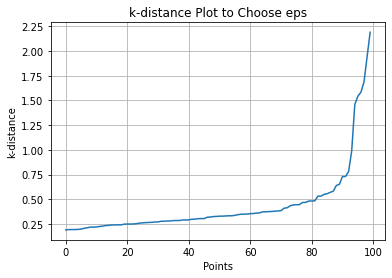

In [5]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

# k = min_samples, usually 4 or 5 for 3D data
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Sort distances to k-th nearest neighbor
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.xlabel('Points')
plt.ylabel('k-distance')
plt.title('k-distance Plot to Choose eps')
plt.grid()
plt.show()


# Apply DBSCAN to This Data

In [6]:
from sklearn.cluster import DBSCAN 

# Apply DBSCAN
db = DBSCAN(eps=0.5, min_samples=5)
labels = db.fit_predict(X_scaled)
df['Cluster'] = labels

df.head()

,Signal_Strength_dBm,Foot_Traffic,Distance_from_Center_m,Cluster
0,-37.14,187.47,10.00,0
1,-32.69,193.13,13.03,0
2,-29.42,169.65,23.01,0
3,-33.35,210.87,17.50,0
4,-25.76,196.22,18.28,0


In [7]:
# Count clusters and noise
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f"Detected clusters: {n_clusters}")
print(f"Noise points: {n_noise}")

Detected clusters: 3
Noise points: 13


#  Visualize Clusters

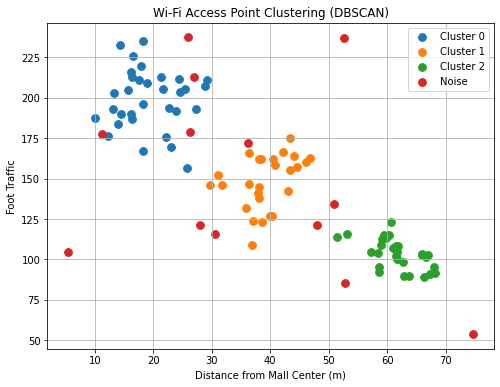

In [8]:
# Plot clusters
import matplotlib.pyplot as plt 

plt.figure(figsize=(8, 6))
for label in set(labels):
    cluster_data = df[df['Cluster'] == label]
    plt.scatter(cluster_data['Distance_from_Center_m'], cluster_data['Foot_Traffic'],
                label=f"Cluster {label}" if label != -1 else "Noise", s=60)
plt.xlabel("Distance from Mall Center (m)")
plt.ylabel("Foot Traffic")
plt.title("Wi-Fi Access Point Clustering (DBSCAN)")
plt.legend()
plt.grid(True)
plt.show()

#  Evaluation (Optional if >1 clusters)

In [9]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X_scaled, labels)
print(f"Silhouette Score: {score:.2f}")

Silhouette Score: 0.53


# Create Segments

In [10]:
maps = {
     0: "Central, strong signal, high traffic (main lobby)",

     1: "Moderate signal, moderate traffic (shops area)",

     2: "Weak signal, lower traffic (far end/corners)"
}
df['segments'] = df['Cluster'].map(maps)
df.sample(7)

,Signal_Strength_dBm,Foot_Traffic,Distance_from_Center_m,Cluster,segments
32,-44.22,138.20,38.01,1,"Moderate signal, moderate traffic (shops area)"
48,-48.43,134.34,50.95,-1,NaN
31,-46.35,144.79,38.06,1,"Moderate signal, moderate traffic (shops area)"
41,-46.27,152.38,31.15,1,"Moderate signal, moderate traffic (shops area)"
14,-32.32,202.95,13.21,0,"Central, strong signal, high traffic (main lobby)"
83,-63.93,104.30,61.65,2,"Weak signal, lower traffic (far end/corners)"
42,-52.73,146.86,36.45,1,"Moderate signal, moderate traffic (shops area)"


# Real Time Clustering/Segmentation System

DBSCAN does not support .predict() for unseen data because it's a non-parametric model.